Data for interval 2024-07-21T18:17:00Z to 2024-07-21T18:18:00Z: [{'metric': {}, 'values': [[1721585820, '0.0008333333333342334'], [1721585821, '0.0008333333333342334'], [1721585822, '0.0009999999999996234'], [1721585823, '0.0009999999999996234'], [1721585824, '0.0009999999999996234'], [1721585825, '0.0009999999999996234'], [1721585826, '0.0009999999999996234'], [1721585827, '0.0006666666666666525'], [1721585828, '0.0006666666666666525'], [1721585829, '0.0006666666666666525'], [1721585830, '0.0006666666666666525'], [1721585831, '0.0006666666666666525'], [1721585832, '0.0004999999999999006'], [1721585833, '0.0004999999999999006'], [1721585834, '0.0004999999999999006'], [1721585835, '0.0004999999999999006'], [1721585836, '0.0004999999999999006'], [1721585837, '0.0006666666666664158'], [1721585838, '0.0006666666666664158'], [1721585839, '0.0006666666666664158'], [1721585840, '0.0006666666666664158'], [1721585841, '0.0006666666666664158'], [1721585842, '0.0008333333333336413'], [1721585843,

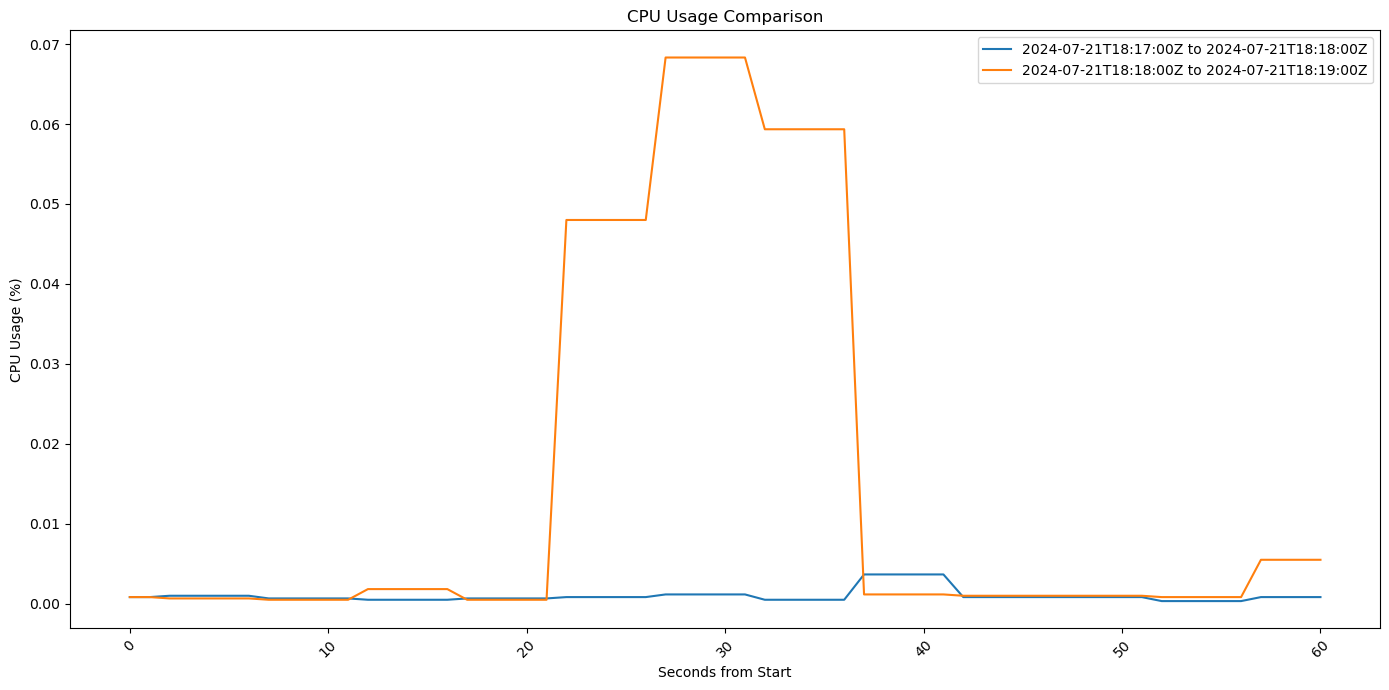

In [10]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Define Prometheus server URL
prometheus_url = 'http://localhost:9090'  # Replace with your actual Prometheus server URL

# Define Prometheus query
query = 'sum(irate(node_cpu_seconds_total{instance="node-exporter:9100", job="node_exporter", mode!="idle"}[5m])) / scalar(count(count(node_cpu_seconds_total{instance="node-exporter:9100", job="node_exporter"}) by (cpu)))'

# Define custom time intervals (1 minute each)
time_intervals = [
    ("2024-07-21T18:17:00Z", "2024-07-21T18:18:00Z"),
    ("2024-07-21T18:18:00Z", "2024-07-21T18:19:00Z")
]

# Function to fetch data from Prometheus
def fetch_data(start, end):
    response = requests.get(f'{prometheus_url}/api/v1/query_range', params={
        'query': query,
        'start': start,
        'end': end,
        'step': '1s'
    })
    response.raise_for_status()  # Check for request errors
    results = response.json()['data']['result']
    print(f"Data for interval {start} to {end}: {results}")
    return results

# Fetch data for both intervals
data1 = fetch_data(*time_intervals[0])
data2 = fetch_data(*time_intervals[1])

# Function to process Prometheus data
def process_data(data):
    if not data:
        print("No data returned from Prometheus.")
        return [], []
    timestamps = [pd.to_datetime(point[0], unit='s') for point in data[0]['values']]
    values = [float(point[1]) for point in data[0]['values']]
    return timestamps, values

# Process data for both intervals
timestamps1, values1 = process_data(data1)
timestamps2, values2 = process_data(data2)

# Normalize timestamps to start from 0
if timestamps1 and timestamps2:
    start_time1 = timestamps1[0]
    start_time2 = timestamps2[0]
    normalized_timestamps1 = [(ts - start_time1).total_seconds() for ts in timestamps1]
    normalized_timestamps2 = [(ts - start_time2).total_seconds() for ts in timestamps2]

    # Plot the data
    plt.figure(figsize=(14, 7))

    plt.plot(normalized_timestamps1, values1, label=f'{time_intervals[0][0]} to {time_intervals[0][1]}')
    plt.plot(normalized_timestamps2, values2, label=f'{time_intervals[1][0]} to {time_intervals[1][1]}')

    plt.xlabel('Seconds from Start')
    plt.ylabel('CPU Usage (%)')
    plt.title('CPU Usage Comparison')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save and show the plot
    plt.savefig('cpu_usage_comparison.png')
    plt.show()
else:
    print("No data to plot.")
